# Text data analysis on Amazon Alexa reviews & ML for classcification prediction

## 1. Import Packages

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns;sns.set()
plt.style.use("seaborn-notebook")
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer; lemmatizer = WordNetLemmatizer()
from nltk import word_tokenize, pos_tag

import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from textblob import Word

from sklearn import metrics,svm,naive_bayes,decomposition, ensemble
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer,LabelEncoder
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import TruncatedSVD

from PIL import Image
from collections import Counter
import datetime
import re

## 2. Data Exploration & Cleaning

In [3]:
df = pd.read_csv('alexa_review.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3071 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [4]:
df.dropna(axis=0, how='any', inplace=True)

In [5]:
df[df.duplicated()]

,rating,date,variation,verified_reviews,feedback
700,5,31-Jul-18,Heather Gray Fabric,I received the echo as a gift. I needed anothe...,1
701,3,31-Jul-18,Sandstone Fabric,"Without having a cellphone, I cannot use many ...",1
702,5,31-Jul-18,Charcoal Fabric,I think this is the 5th one I've purchased. I'...,1
703,5,30-Jul-18,Heather Gray Fabric,looks great,1
704,5,30-Jul-18,Heather Gray Fabric,Love it! I’ve listened to songs I haven’t hear...,1
...,...,...,...,...,...
3145,5,30-Jul-18,Black Dot,"Perfect for kids, adults and everyone in betwe...",1
3146,5,30-Jul-18,Black Dot,"Listening to music, searching locations, check...",1
3147,5,30-Jul-18,Black Dot,"I do love these things, i have them running my...",1
3148,5,30-Jul-18,White Dot,Only complaint I have is that the sound qualit...,1


In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2385 entries, 0 to 2800
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            2385 non-null   int64 
 1   date              2385 non-null   object
 2   variation         2385 non-null   object
 3   verified_reviews  2385 non-null   object
 4   feedback          2385 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 111.8+ KB


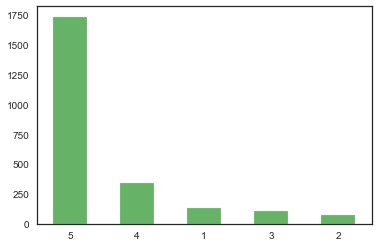

In [39]:
df.rating.value_counts().plot.bar(color = "green", alpha = 0.6)
plt.xticks(rotation = 0)
plt.show()

#### Data distribution is unbalanced - use stratify sampling for later ML

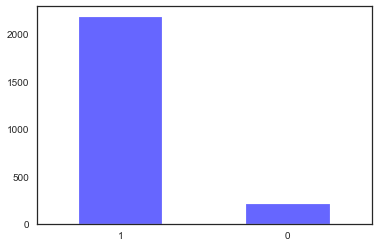

In [40]:
df.feedback.value_counts().plot.bar(color = "blue", alpha = 0.6)
plt.xticks(rotation = 0)
plt.show()

In [10]:
df.feedback.value_counts()

1    2179
0     206
Name: feedback, dtype: int64

In [11]:
df.variation.value_counts()

Configuration: Fire TV Stick    336
Black  Plus                     261
Black                           258
Black  Show                     256
Black  Dot                      247
Black  Spot                     235
Charcoal Fabric                 219
White  Spot                     104
White  Dot                       90
White                            88
White  Show                      82
Heather Gray Fabric              77
White  Plus                      76
Sandstone Fabric                 44
Oak Finish                        7
Walnut Finish                     5
Name: variation, dtype: int64

#### Quantify Sentiment Distribution in Product Feedback

In [12]:
print("Sentiment Distribution Per Product\n")
for i in df.variation.unique():
    x = df[df.variation == i]["feedback"].value_counts()/df[df.variation == i].shape[0]
    print(f"{i}:\n1:{np.round(x[1]*100,1)}%\n0:{np.round((1-x[1])*100,1)}%\n")

Sentiment Distribution Per Product

Charcoal Fabric:
1:97.3%
0:2.7%

Walnut Finish:
1:100.0%
0:0.0%

Heather Gray Fabric:
1:98.7%
0:1.3%

Sandstone Fabric:
1:93.2%
0:6.8%

Oak Finish:
1:100.0%
0:0.0%

Black:
1:86.8%
0:13.2%

White:
1:83.0%
0:17.0%

Black  Spot:
1:87.2%
0:12.8%

White  Spot:
1:91.3%
0:8.7%

Black  Show:
1:93.4%
0:6.6%

White  Show:
1:87.8%
0:12.2%

Black  Plus:
1:89.7%
0:10.3%

White  Plus:
1:90.8%
0:9.2%

Configuration: Fire TV Stick:
1:92.6%
0:7.4%

Black  Dot:
1:93.1%
0:6.9%

White  Dot:
1:94.4%
0:5.6%



## 3. Text Analysis

In [13]:
df.drop(["date","variation"], axis=1, inplace=True)

In [14]:
# text cleaning includes: lower words, delete punctuations & stop words, lemmatization
df['verified_reviews'] = df['verified_reviews'].apply(lambda x: ' '.join(x.lower() for x in x.split()))
df['verified_reviews'] = df['verified_reviews'].str.replace('[^\w\s]', '')
df['verified_reviews'] = df['verified_reviews'].apply(lambda x: ' '.join([Word(word).lemmatize() for word in x.split()]))
df['verified_reviews'] = df['verified_reviews'].apply(lambda x: ' '.join(x
        for x in x.split() if x not in stopwords.words('english')))
df.head()

,rating,verified_reviews,feedback
0,5,love echo,1
1,5,loved,1
2,4,sometimes playing game answer question correct...,1
3,5,lot fun thing 4 yr old learns dinosaur control...,1
4,5,music,1


#### WordCloud Visualization for Word Frequency

In [15]:
def word_cloud(dataframe, rating):
    

    df_review = dataframe[df.rating == rating]
    text_list = df_review["verified_reviews"].tolist()
    text_list = " ".join(text_list)
    text_tokens = nltk.word_tokenize(text_list)
    

    wordcloud = WordCloud(mask = np.array(Image.open("cloud.png")), max_words = 100,
                          background_color = "white",
                          stopwords = stopwords.words("english"), min_font_size = 5).generate(text_list)
    plt.figure(figsize = (5,5), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    
    plt.show()
    

    count_word = Counter(text_tokens)
    count_word = sorted(count_word.items(), key = lambda x:x[1], reverse = True)
    print(f"top 20 words in {rating}-star reviews: \n")
    print(pd.Series(dict(count_word[0:20])))

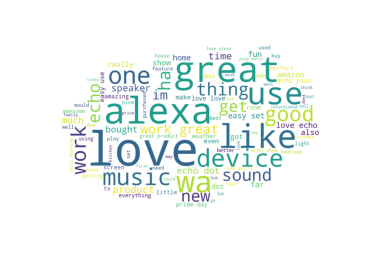

top 20 words in 5-star reviews: 

love       687
great      438
echo       424
alexa      282
work       272
use        252
music      245
like       240
easy       230
one        203
wa         198
sound      182
set        168
device     157
dot        152
product    149
thing      136
good       130
show       122
new        121
dtype: int64


In [16]:
word_cloud(df,5)

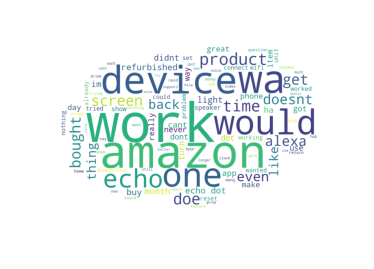

top 20 words in 1-star reviews: 

echo           44
work           41
amazon         41
wa             29
device         29
would          29
one            28
dot            25
product        24
time           22
doe            21
thing          19
get            19
bought         19
screen         19
refurbished    17
doesnt         17
alexa          16
even           16
back           15
dtype: int64


In [17]:
word_cloud(df,1)

## Machine Learning for Review Classification

#### Encode text data

In [18]:
x_train, x_test, y_train, y_test = train_test_split(
         df['verified_reviews'], df['rating'], stratify=df['rating'],
         test_size=0.2, random_state=42,
         )

In [19]:
text_encoder = Pipeline([
    ('tf-idf', TfidfVectorizer(ngram_range=(1, 2), min_df = 5, max_df = 0.9)),
    ('svd', TruncatedSVD(n_components = 50))], verbose=True)

In [20]:
x_train_vec = text_encoder.fit_transform(x_train)
x_test_vec = text_encoder.transform(x_test)

[Pipeline] ............ (step 1 of 2) Processing tf-idf, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing svd, total=   0.0s


#### Try Basic Tree Classifier

In [21]:
from sklearn.tree import DecisionTreeClassifier

In [22]:
dt =  DecisionTreeClassifier(max_depth=20)

In [23]:
dt.fit(x_train_vec, y_train)

DecisionTreeClassifier(max_depth=20)

#### Evaluate Model Performance

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

In [25]:
accuracy_score(dt.predict(x_train_vec), y_train)

0.9821802935010482

In [26]:
accuracy_score(dt.predict(x_test_vec), y_test)

0.6352201257861635

In [27]:
print('Classification Report')
print(classification_report(dt.predict(x_test_vec), y_test))

Classification Report
              precision    recall  f1-score   support

           1       0.19      0.26      0.22        19
           2       0.07      0.09      0.08        11
           3       0.14      0.10      0.12        30
           4       0.25      0.26      0.25        66
           5       0.80      0.79      0.79       351

    accuracy                           0.64       477
   macro avg       0.29      0.30      0.29       477
weighted avg       0.64      0.64      0.64       477



Confusion Matrix


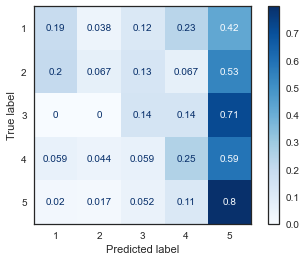

In [28]:
plt.style.use("seaborn-white")
print('Confusion Matrix')
disp = plot_confusion_matrix(dt, x_test_vec, y_test, cmap=plt.cm.Blues, normalize='true')

#### Try Deep Learning - PyTorch

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset

import sys
import re
import json
from collections import Counter
from typing import List, Tuple, Dict
from PIL import Image

In [30]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, vecs, labels):
        'Initialization'
        self.labels = labels
        self.vecs = vecs

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.labels)

  def __getitem__(self, index):
        'Generates one sample of data'
        X = torch.as_tensor(self.vecs[index, :], dtype=torch.float32)
        y = torch.as_tensor(self.labels[index]-1, dtype=torch.long)
        return X, y

In [31]:
training_data = Dataset(x_train_vec, y_train.values)
train_loader = DataLoader(training_data, batch_size=32, shuffle=True)

validation_data = Dataset(x_test_vec, y_test.values)
val_loader = DataLoader(validation_data, batch_size=32, shuffle=True)

In [32]:
INPUT_DIM = x_train_vec.shape[1]
HIDDEN_DIM_1 = 256
HIDDEN_DIM_2 = 128
NUN_CLASS = 5

In [33]:
class ReviewClassify(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(INPUT_DIM, HIDDEN_DIM_1)
        self.fc2 = nn.Linear(HIDDEN_DIM_1, HIDDEN_DIM_2)
        self.fc3 = nn.Linear(HIDDEN_DIM_2, NUN_CLASS)
        self.output = nn.LogSoftmax(dim=1)

    def forward(self, text_vec):
        output_layer1 = self.fc1(text_vec)
        layer_1 = F.relu(output_layer1)
        output_layer2 = self.fc2(layer_1)
        layer_2 = F.relu(output_layer2)
        layer_3 = self.fc3(layer_2)
        output = self.output(layer_3)
        return output

In [34]:
classfier = ReviewClassify()
classfier

ReviewClassify(
  (fc1): Linear(in_features=50, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=5, bias=True)
  (output): LogSoftmax(dim=1)
)

In [35]:
import torch.optim as optim
from torch.autograd import Variable
import time
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classfier.parameters())

In [36]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
losses = []
for epoch in range(200):
    start_time = time.time()
    for x_batch, y_batch in train_loader:

        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        x = Variable(x_batch)
        y = Variable(y_batch)
        output = classfier(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss = loss.item()
        losses.append(train_loss)
    train_acc = (output.argmax(1) == y_batch).sum().true_divide(len(y_batch))
    secs = int(time.time() - start_time)
    mins = secs / 60
    secs = secs % 60
    print('Epoch: %d' %(epoch + 1), " | time in %d minutes, %d seconds" %(mins, secs))
    print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)')
        
    with torch.no_grad():
        losses = []
        val_acc = 0
        for x_batch, y_batch in val_loader:
            # Transfer to GPU
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            x = Variable(x_batch)
            y = Variable(y_batch)
            classfier.eval()
            output = classfier(x)
            loss = criterion(output, y)
            val_acc = (output.argmax(1) == y_batch).sum()
            
            losses.append(loss.item())
            
        val_loss = sum(losses) * 32 / len(y_batch) 
        print(val_acc, len(y_batch))
        val_acc = val_acc.true_divide(len(y_batch))
        print(f'\tVal Loss: {val_loss:.4f}(val)\t|\tVal Acc: {val_acc * 100:.1f}%(val)')

Epoch: 1  | time in 0 minutes, 0 seconds
	Loss: 1.0168(train)	|	Acc: 65.0%(train)
tensor(22) 29
	Val Loss: 14.2056(val)	|	Val Acc: 75.9%(val)
Epoch: 2  | time in 0 minutes, 0 seconds
	Loss: 0.8429(train)	|	Acc: 75.0%(train)
tensor(21) 29
	Val Loss: 13.2875(val)	|	Val Acc: 72.4%(val)
Epoch: 3  | time in 0 minutes, 0 seconds
	Loss: 1.2392(train)	|	Acc: 50.0%(train)
tensor(22) 29
	Val Loss: 12.6569(val)	|	Val Acc: 75.9%(val)
Epoch: 4  | time in 0 minutes, 0 seconds
	Loss: 0.7012(train)	|	Acc: 70.0%(train)
tensor(20) 29
	Val Loss: 12.4801(val)	|	Val Acc: 69.0%(val)
Epoch: 5  | time in 0 minutes, 0 seconds
	Loss: 0.3242(train)	|	Acc: 90.0%(train)
tensor(19) 29
	Val Loss: 12.3867(val)	|	Val Acc: 65.5%(val)
Epoch: 6  | time in 0 minutes, 0 seconds
	Loss: 0.8643(train)	|	Acc: 70.0%(train)
tensor(20) 29
	Val Loss: 12.3674(val)	|	Val Acc: 69.0%(val)
Epoch: 7  | time in 0 minutes, 0 seconds
	Loss: 0.7594(train)	|	Acc: 70.0%(train)
tensor(20) 29
	Val Loss: 12.3459(val)	|	Val Acc: 69.0%(val)
Epoch:

Epoch: 61  | time in 0 minutes, 0 seconds
	Loss: 0.1123(train)	|	Acc: 95.0%(train)
tensor(20) 29
	Val Loss: 25.8388(val)	|	Val Acc: 69.0%(val)
Epoch: 62  | time in 0 minutes, 0 seconds
	Loss: 0.3549(train)	|	Acc: 90.0%(train)
tensor(20) 29
	Val Loss: 27.0873(val)	|	Val Acc: 69.0%(val)
Epoch: 63  | time in 0 minutes, 0 seconds
	Loss: 0.0473(train)	|	Acc: 100.0%(train)
tensor(20) 29
	Val Loss: 26.6776(val)	|	Val Acc: 69.0%(val)
Epoch: 64  | time in 0 minutes, 0 seconds
	Loss: 0.1625(train)	|	Acc: 95.0%(train)
tensor(19) 29
	Val Loss: 27.2057(val)	|	Val Acc: 65.5%(val)
Epoch: 65  | time in 0 minutes, 0 seconds
	Loss: 0.2074(train)	|	Acc: 95.0%(train)
tensor(21) 29
	Val Loss: 26.3394(val)	|	Val Acc: 72.4%(val)
Epoch: 66  | time in 0 minutes, 0 seconds
	Loss: 0.1730(train)	|	Acc: 90.0%(train)
tensor(17) 29
	Val Loss: 27.1380(val)	|	Val Acc: 58.6%(val)
Epoch: 67  | time in 0 minutes, 0 seconds
	Loss: 0.0895(train)	|	Acc: 95.0%(train)
tensor(21) 29
	Val Loss: 27.5166(val)	|	Val Acc: 72.4%(val

Epoch: 118  | time in 0 minutes, 0 seconds
	Loss: 0.0211(train)	|	Acc: 100.0%(train)
tensor(20) 29
	Val Loss: 34.6505(val)	|	Val Acc: 69.0%(val)
Epoch: 119  | time in 0 minutes, 0 seconds
	Loss: 0.0131(train)	|	Acc: 100.0%(train)
tensor(19) 29
	Val Loss: 35.4016(val)	|	Val Acc: 65.5%(val)
Epoch: 120  | time in 0 minutes, 0 seconds
	Loss: 0.0035(train)	|	Acc: 100.0%(train)
tensor(22) 29
	Val Loss: 35.3078(val)	|	Val Acc: 75.9%(val)
Epoch: 121  | time in 0 minutes, 0 seconds
	Loss: 0.0172(train)	|	Acc: 100.0%(train)
tensor(12) 29
	Val Loss: 35.9295(val)	|	Val Acc: 41.4%(val)
Epoch: 122  | time in 0 minutes, 0 seconds
	Loss: 0.0251(train)	|	Acc: 100.0%(train)
tensor(17) 29
	Val Loss: 36.1402(val)	|	Val Acc: 58.6%(val)
Epoch: 123  | time in 0 minutes, 0 seconds
	Loss: 0.0333(train)	|	Acc: 100.0%(train)
tensor(19) 29
	Val Loss: 35.1762(val)	|	Val Acc: 65.5%(val)
Epoch: 124  | time in 0 minutes, 0 seconds
	Loss: 0.0085(train)	|	Acc: 100.0%(train)
tensor(24) 29
	Val Loss: 34.8879(val)	|	Val A

Epoch: 175  | time in 0 minutes, 0 seconds
	Loss: 0.0106(train)	|	Acc: 100.0%(train)
tensor(16) 29
	Val Loss: 40.0397(val)	|	Val Acc: 55.2%(val)
Epoch: 176  | time in 0 minutes, 0 seconds
	Loss: 0.4082(train)	|	Acc: 90.0%(train)
tensor(18) 29
	Val Loss: 40.2660(val)	|	Val Acc: 62.1%(val)
Epoch: 177  | time in 0 minutes, 0 seconds
	Loss: 0.0125(train)	|	Acc: 100.0%(train)
tensor(19) 29
	Val Loss: 38.9412(val)	|	Val Acc: 65.5%(val)
Epoch: 178  | time in 0 minutes, 0 seconds
	Loss: 0.0045(train)	|	Acc: 100.0%(train)
tensor(19) 29
	Val Loss: 38.6387(val)	|	Val Acc: 65.5%(val)
Epoch: 179  | time in 0 minutes, 0 seconds
	Loss: 0.0150(train)	|	Acc: 100.0%(train)
tensor(15) 29
	Val Loss: 39.3880(val)	|	Val Acc: 51.7%(val)
Epoch: 180  | time in 0 minutes, 0 seconds
	Loss: 0.0645(train)	|	Acc: 100.0%(train)
tensor(15) 29
	Val Loss: 38.9906(val)	|	Val Acc: 51.7%(val)
Epoch: 181  | time in 0 minutes, 0 seconds
	Loss: 0.0031(train)	|	Acc: 100.0%(train)
tensor(17) 29
	Val Loss: 39.8983(val)	|	Val Ac